<a href="https://colab.research.google.com/github/rtajeong/M3_new_2025/blob/main/lab37_randomforest_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 랜덤포레스트
- uses Majority Voting (for classification)
- uses average (for regression)

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm, metrics
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

## 결정트리

In [2]:
cancer = load_breast_cancer()
np.random.seed(9)
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.916083916083916

In [3]:
len(y_train[y_train==1])/len(y_train), len(y_test[y_test==1])/len(y_test)

(0.6267605633802817, 0.6293706293706294)

In [4]:
print(clf.score(X_test, y_test))

0.916083916083916


In [5]:
X_train.shape, X_test.shape, cancer.data.shape

((426, 30), (143, 30), (569, 30))

### feature_importances_:
- In trees, it tells how much each feature contributes to decreasing the
  weighted impurity.
- in Random Forest, it averages the decrease in impurity over trees.

In [6]:
# 결정 트리를 사용한 경우의 중요 변수

list(zip(cancer.feature_names, clf.feature_importances_.round(4)))[:10]

[(np.str_('mean radius'), np.float64(0.0)),
 (np.str_('mean texture'), np.float64(0.0417)),
 (np.str_('mean perimeter'), np.float64(0.0)),
 (np.str_('mean area'), np.float64(0.0)),
 (np.str_('mean smoothness'), np.float64(0.0)),
 (np.str_('mean compactness'), np.float64(0.0)),
 (np.str_('mean concavity'), np.float64(0.0)),
 (np.str_('mean concave points'), np.float64(0.0426)),
 (np.str_('mean symmetry'), np.float64(0.0114)),
 (np.str_('mean fractal dimension'), np.float64(0.0))]

In [7]:
df = pd.DataFrame({'feature':cancer.feature_names,'importance':clf.feature_importances_ })
df=df.sort_values('importance', ascending=False)
print(df.head(10))

                 feature  importance
22       worst perimeter    0.694689
27  worst concave points    0.121068
7    mean concave points    0.042647
1           mean texture    0.041720
21         worst texture    0.039639
13            area error    0.017216
20          worst radius    0.017188
15     compactness error    0.012042
8          mean symmetry    0.011405
14      smoothness error    0.002385


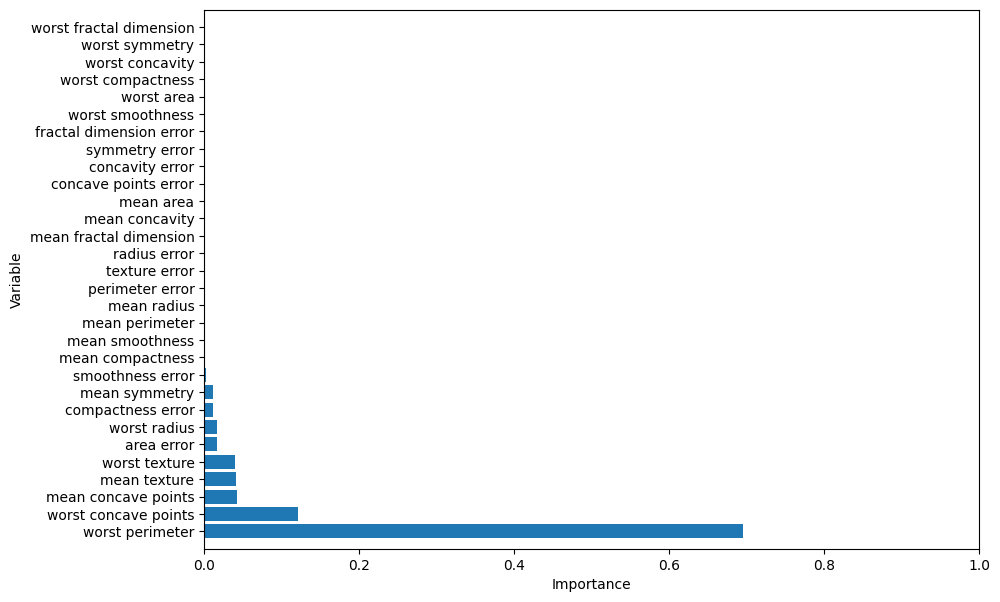

In [8]:
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

0.951048951048951


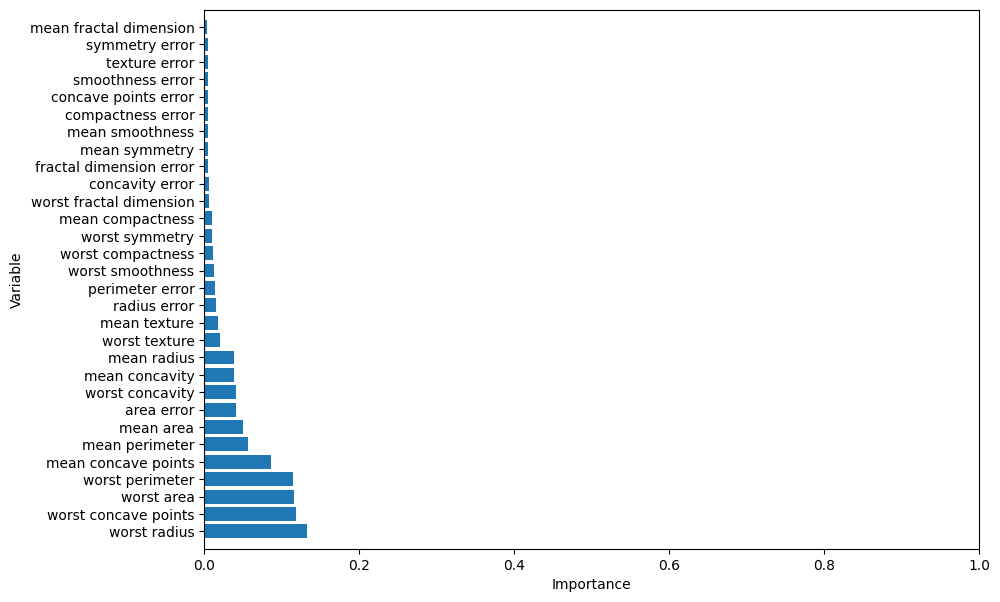

In [9]:
# 랜덤 포레스트를 사용한 경우의 중요 특성

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))

df = pd.DataFrame({'feature':cancer.feature_names,'importance':rfc.feature_importances_ })
df=df.sort_values('importance', ascending=False)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

- 골고루 사용됨을 알 수 있다.

- ExtraTrees:
  - As in random forests, a random subset of candidate features is used.
  - but instead of looking for the most discriminative thresholds, **thresholds are drawn at random** for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule
  - This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

0.972027972027972


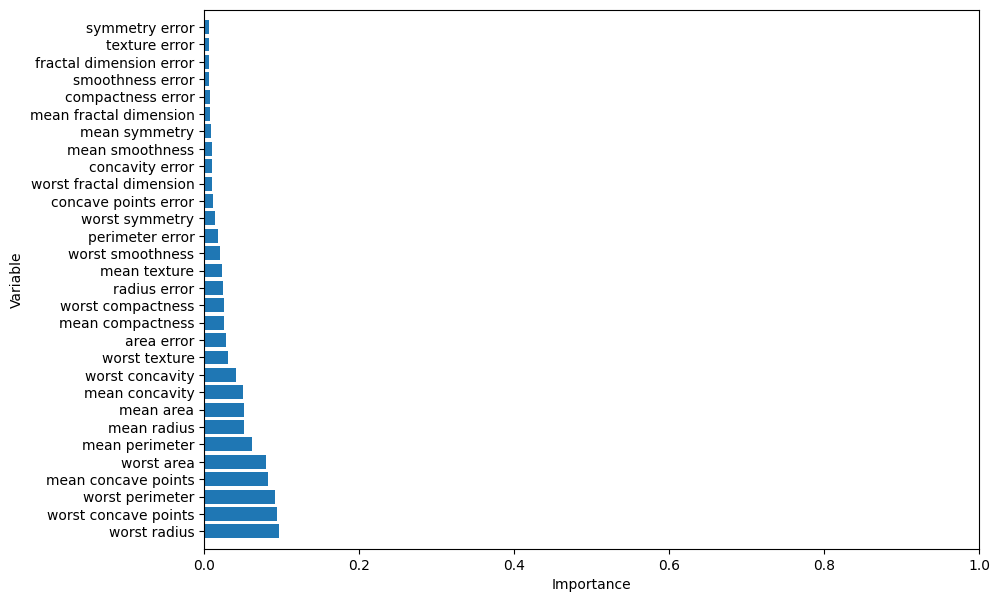

In [10]:
# ExtraTrees
from sklearn.ensemble import ExtraTreesClassifier
etf = ExtraTreesClassifier(n_estimators=500)
etf.fit(X_train, y_train)
print(etf.score(X_test, y_test))

df = pd.DataFrame({'feature':cancer.feature_names,'importance':etf.feature_importances_ })
df=df.sort_values('importance', ascending=False)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

Boosting 방법을 써보자

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=500)
gbc.fit(X_train, y_train)
print(gbc.score(X_test, y_test))

0.9790209790209791


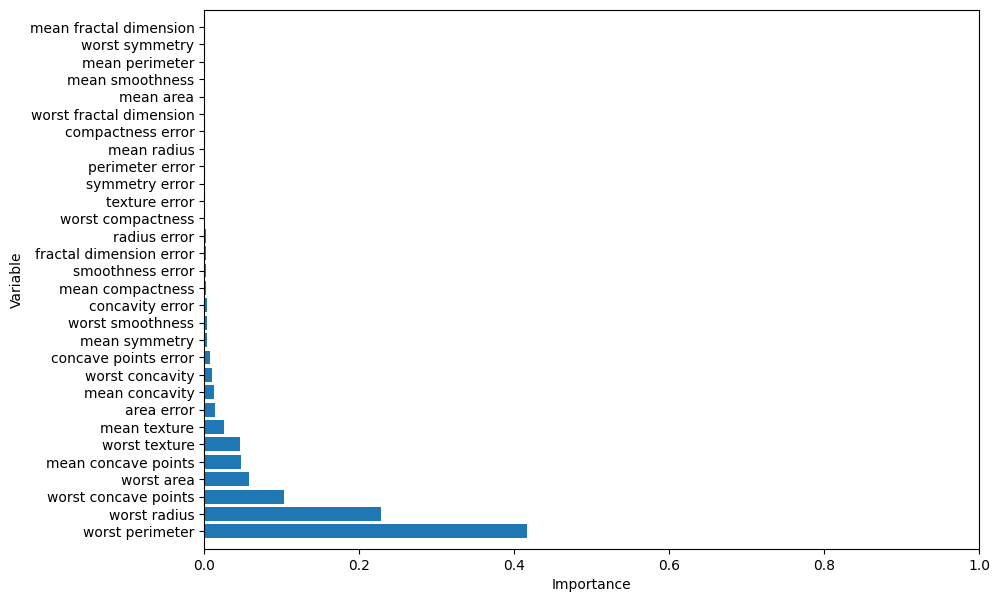

In [12]:
df = pd.DataFrame({'feature':cancer.feature_names,'importance':gbc.feature_importances_ })
df = df.sort_values('importance', ascending=False)
x = df.feature
y = df.importance
ypos = np.arange(len(x))

plt.figure(figsize=(10,7))
plt.barh(x, y)
plt.yticks(ypos, x)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.xlim(0, 1)
plt.ylim(-1, len(x))
plt.show()

## Voting Classifier
- combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote).

In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(max_iter=4000)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf1 = VotingClassifier(
                     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                     voting='hard')  # str must be unique (seems to be redundant...?)
eclf2 = VotingClassifier(
                     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
                     voting='soft')

for clf, label in zip([clf1, clf2, clf3, eclf1, eclf2],
                      ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble1', 'Ensemble2']):
     scores = cross_val_score(clf, cancer.data, cancer.target, scoring='accuracy', cv=5)
     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.02) [Logistic Regression]
Accuracy: 0.96 (+/- 0.02) [Random Forest]
Accuracy: 0.94 (+/- 0.01) [naive Bayes]
Accuracy: 0.95 (+/- 0.02) [Ensemble1]
Accuracy: 0.95 (+/- 0.01) [Ensemble2]


----------------------------